In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import pickle
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function to load datasets with error handling
def load_dataset(file_path, description):
    try:
        df = pd.read_csv(file_path)
        print(f"Loaded {description} data: {df.shape[0]} rows, {df.shape[1]} columns")
        return df
    except Exception as e:
        print(f"Error loading {description} data from {file_path}: {e}")
        # Return empty DataFrame with expected columns if possible
        return pd.DataFrame()

In [3]:
# Load all datasets
print("Loading all datasets...")
df_daily = load_dataset('salesdaily.csv', 'daily')
df_hourly = load_dataset('saleshourly.csv', 'hourly')
df_monthly = load_dataset('salesmonthly.csv', 'monthly')
df_weekly = load_dataset('salesweekly.csv', 'weekly')

Loading all datasets...
Loaded daily data: 2106 rows, 13 columns
Loaded hourly data: 50532 rows, 13 columns
Loaded monthly data: 70 rows, 9 columns
Loaded weekly data: 302 rows, 9 columns


In [4]:
# Enhanced data cleaning function
def clean_data(df, name):
    if df.empty:
        print(f"Warning: Empty DataFrame provided to clean_data for {name} dataset")
        return df
        
    print(f"\nCleaning {name} data with original shape: {df.shape}")
    
    # Clean column names
    df.columns = df.columns.str.strip().str.lower()
    
    # Print top rows for inspection
    print(f"First few rows of {name} data:")
    print(df.head(2))
    
    # Convert date columns to datetime if they exist
    if 'datum' in df.columns:
        df['datum'] = pd.to_datetime(df['datum'], errors='coerce')
        # Check for NaT values after conversion
        nat_count = df['datum'].isna().sum()
        if nat_count > 0:
            print(f"Warning: {nat_count} NaT values found in 'datum' column after conversion")
            # Drop rows with NaT values in datum to avoid errors later
            df = df.dropna(subset=['datum'])
            print(f"Dropped rows with NaT in datum. New shape: {df.shape}")
    
    # Check for missing values
    missing_values = df.isna().sum()
    total_missing = missing_values.sum()
    if total_missing > 0:
        print(f"Found {total_missing} missing values in {name} dataset")
        
        # Handle missing values in columns
        numeric_cols = df.select_dtypes(include=['number']).columns
        categorical_cols = df.select_dtypes(include=['object']).columns
        
        # Fill numeric columns with median
        for col in numeric_cols:
            missing_count = df[col].isna().sum()
            if missing_count > 0:
                print(f"Filling {missing_count} missing values in '{col}' with median")
                df[col] = df[col].fillna(df[col].median())
        
        # Fill categorical columns with mode
        for col in categorical_cols:
            missing_count = df[col].isna().sum()
            if missing_count > 0:
                mode_value = df[col].mode()[0] if not df[col].mode().empty else 'Unknown'
                print(f"Filling {missing_count} missing values in '{col}' with mode: '{mode_value}'")
                df[col] = df[col].fillna(mode_value)
    
    # Ensure 'weekday name' column is present if 'datum' is available
    if 'datum' in df.columns and 'weekday name' not in df.columns:
        print(f"Adding 'weekday name' column to {name} dataset from 'datum'")
        df['weekday name'] = df['datum'].dt.day_name()
    
    print(f"Cleaned {name} data shape: {df.shape}")
    return df


In [5]:
# Function to check for data leakage
def check_data_leakage(df, target_col='weekday name', name='dataset'):
    if df.empty:
        print(f"Warning: Empty DataFrame provided to check_data_leakage for {name}")
        return df
        
    print(f"\nChecking for potential data leakage in {name} ({df.shape[0]} rows)...")
    
    # Check if target column exists
    if target_col not in df.columns:
        print(f"Warning: Target column '{target_col}' not found in {name}. Columns: {df.columns.tolist()}")
        if 'datum' in df.columns:
            print(f"Creating '{target_col}' from 'datum' column")
            df[target_col] = df['datum'].dt.day_name()
        else:
            return df
    
    # Check for duplicates
    duplicate_count = df.duplicated().sum()
    print(f"Number of duplicate rows: {duplicate_count}")
    if duplicate_count > 0:
        df = df.drop_duplicates()
        print(f"Duplicates removed. New shape: {df.shape}")
        # Check for direct leakage features
    potential_leakage = [col for col in df.columns if 'weekday' in col.lower() and col != target_col]
    if potential_leakage:
        print(f"Potential leakage features found in {name}: {potential_leakage}")
        df = df.drop(columns=potential_leakage)
        print(f"Removed leakage features. New shape: {df.shape}")
    
    # Check correlations for numerical indicators of leakage
    if df.shape[0] > 5:  # Only check if we have enough data
        try:
            df_corr = df.copy()
            df_corr[f'{target_col}_numeric'] = pd.factorize(df_corr[target_col])[0]
            
            # Calculate correlations only for numeric columns
            numeric_df = df_corr.select_dtypes(include=['number'])
            if len(numeric_df.columns) > 1:
                corr_matrix = numeric_df.corr()
                if f'{target_col}_numeric' in corr_matrix:
                    target_corrs = corr_matrix[f'{target_col}_numeric'].sort_values(ascending=False)
                    high_corr = target_corrs[(target_corrs > 0.7) & (target_corrs < 1.0)]
                    if not high_corrs.empty:
                        print(f"\nFeatures highly correlated with target in {name}:")
                        print(high_corr)
        except Exception as e:
            print(f"Error calculating correlations in {name}: {e}")
    
    return df

In [6]:
# Function to perform feature engineering
def engineer_features(df, name='dataset', remove_leakage=True):
    if df.empty:
        print(f"Warning: Empty DataFrame provided to engineer_features for {name}")
        return df
        
    print(f"\nPerforming feature engineering on {name} data...")
    
    # Ensure we have 'datum' for date-based features
    if 'datum' not in df.columns:
        print(f"Warning: 'datum' column not found in {name}. Limited feature engineering possible.")
        return df
    
    try:
        # Extract date components
        df['year'] = df['datum'].dt.year
        df['month'] = df['datum'].dt.month
        df['day'] = df['datum'].dt.day
        df['quarter'] = df['datum'].dt.quarter
        df['day_of_year'] = df['datum'].dt.dayofyear
        df['is_weekend'] = df['datum'].dt.dayofweek >= 5  # 5=Saturday, 6=Sunday
        
        # Ensure target column exists
        if 'weekday name' not in df.columns:
            print(f"Adding 'weekday name' to {name} dataset")
            df['weekday name'] = df['datum'].dt.day_name()
        
        # Add fiscal quarter (assuming fiscal year starts in April)
        month_fiscal = np.where(df['month'] >= 4, df['month'] - 3, df['month'] + 9)
        df['fiscal_quarter'] = np.ceil(month_fiscal / 3).astype(int)
        
        # Add season feature
        df['season'] = df['month'].apply(lambda x: 
                                         'Winter' if x in [12, 1, 2] else
                                         'Spring' if x in [3, 4, 5] else
                                         'Summer' if x in [6, 7, 8] else 'Fall')
        
        # For hourly data, add time-of-day features
        if 'hour' in df.columns:
            df['time_of_day'] = df['hour'].apply(lambda x: 
                                                'Morning' if 5 <= x < 12 else
                                                'Afternoon' if 12 <= x < 17 else
                                                'Evening' if 17 <= x < 21 else 'Night')
            
            df['is_business_hours'] = df['hour'].apply(lambda x: 1 if 9 <= x < 17 else 0)
        
        # For monthly data, add month_name feature
        if 'month' in df.columns:
            month_names = {
                1: 'January', 2: 'February', 3: 'March', 4: 'April', 
                5: 'May', 6: 'June', 7: 'July', 8: 'August',
                9: 'September', 10: 'October', 11: 'November', 12: 'December'
            }
            df['month_name'] = df['month'].map(month_names)
        
        # Remove datum if specified to prevent leakage
        if remove_leakage and 'datum' in df.columns:
            df = df.drop(columns=['datum'])
            print(f"Removed 'datum' column from {name} to prevent direct date leakage")
        
        print(f"Completed feature engineering for {name}. New shape: {df.shape}")
        print(f"Engineered features: {[col for col in df.columns if col not in ['weekday name', 'datum']][:10]}...")
        
    except Exception as e:
        print(f"Error in feature engineering for {name}: {e}")
    
    return df

In [7]:
# Clean and prepare all datasets
print("\n--- Cleaning and preparing all datasets ---")
df_daily = clean_data(df_daily, 'daily')
df_hourly = clean_data(df_hourly, 'hourly')
df_monthly = clean_data(df_monthly, 'monthly')
df_weekly = clean_data(df_weekly, 'weekly')


--- Cleaning and preparing all datasets ---

Cleaning daily data with original shape: (2106, 13)
First few rows of daily data:
      datum  m01ab  m01ae  n02ba  n02be  n05b  n05c   r03  r06  year  month  \
0  1/2/2014    0.0   3.67    3.4   32.4   7.0   0.0   0.0  2.0  2014      1   
1  1/3/2014    8.0   4.00    4.4   50.6  16.0   0.0  20.0  4.0  2014      1   

   hour weekday name  
0   248     Thursday  
1   276       Friday  
Cleaned daily data shape: (2106, 13)

Cleaning hourly data with original shape: (50532, 13)
First few rows of hourly data:
           datum  m01ab  m01ae  n02ba  n02be  n05b  n05c  r03  r06  year  \
0  1/2/2014 8:00    0.0   0.67    0.4    2.0   0.0   0.0  0.0  1.0  2014   
1  1/2/2014 9:00    0.0   0.00    1.0    0.0   2.0   0.0  0.0  0.0  2014   

   month  hour weekday name  
0      1     8     Thursday  
1      1     9     Thursday  
Cleaned hourly data shape: (50532, 13)

Cleaning monthly data with original shape: (70, 9)
First few rows of monthly data:


In [8]:
# Check for data leakage in each dataset
df_daily = check_data_leakage(df_daily, name='daily')
df_hourly = check_data_leakage(df_hourly, name='hourly')
df_monthly = check_data_leakage(df_monthly, name='monthly')
df_weekly = check_data_leakage(df_weekly, name='weekly')



Checking for potential data leakage in daily (2106 rows)...
Number of duplicate rows: 0
Error calculating correlations in daily: name 'high_corrs' is not defined

Checking for potential data leakage in hourly (50532 rows)...
Number of duplicate rows: 0
Error calculating correlations in hourly: name 'high_corrs' is not defined

Checking for potential data leakage in monthly (70 rows)...
Number of duplicate rows: 0
Error calculating correlations in monthly: name 'high_corrs' is not defined

Checking for potential data leakage in weekly (302 rows)...
Number of duplicate rows: 0
Error calculating correlations in weekly: name 'high_corrs' is not defined


In [9]:
# Engineer features for each dataset
df_daily = engineer_features(df_daily, 'daily')
df_hourly = engineer_features(df_hourly, 'hourly')
df_monthly = engineer_features(df_monthly, 'monthly')
df_weekly = engineer_features(df_weekly, 'weekly')



Performing feature engineering on daily data...
Removed 'datum' column from daily to prevent direct date leakage
Completed feature engineering for daily. New shape: (2106, 21)
Engineered features: ['m01ab', 'm01ae', 'n02ba', 'n02be', 'n05b', 'n05c', 'r03', 'r06', 'year', 'month']...

Performing feature engineering on hourly data...
Removed 'datum' column from hourly to prevent direct date leakage
Completed feature engineering for hourly. New shape: (50532, 21)
Engineered features: ['m01ab', 'm01ae', 'n02ba', 'n02be', 'n05b', 'n05c', 'r03', 'r06', 'year', 'month']...

Performing feature engineering on monthly data...
Removed 'datum' column from monthly to prevent direct date leakage
Completed feature engineering for monthly. New shape: (70, 18)
Engineered features: ['m01ab', 'm01ae', 'n02ba', 'n02be', 'n05b', 'n05c', 'r03', 'r06', 'year', 'month']...

Performing feature engineering on weekly data...
Removed 'datum' column from weekly to prevent direct date leakage
Completed feature eng

In [10]:
# Function to prepare dataset for modeling
def prepare_dataset(df, target_col='weekday name', name='dataset'):
    if df.empty:
        print(f"Warning: Empty DataFrame provided to prepare_dataset for {name}")
        return None, None
        
    if target_col not in df.columns:
        print(f"Warning: Target column '{target_col}' not found in {name}. Available columns: {df.columns.tolist()}")
        return None, None
    
    # Print dataset info
    print(f"\nPreparing {name} dataset for modeling. Shape: {df.shape}")
    
    # Check target distribution
    target_counts = df[target_col].value_counts()
    print(f"Target distribution in {name}:")
    print(target_counts)
    
    # Handle rare classes if necessary
    min_class_count = target_counts.min()
    if min_class_count < 2:
        print(f"Warning: Some target classes have only {min_class_count} samples in {name}!")
        print("This may cause issues with stratification in train-test split.")
        print("Removing classes with fewer than 2 samples...")
        rare_classes = target_counts[target_counts < 2].index
        df = df[~df[target_col].isin(rare_classes)]
        print(f"After removing rare classes. New shape: {df.shape}")
    
    # Identify categorical and numerical columns
    categorical_features = []
    numerical_features = []
    
    for col in df.columns:
        # Skip target column
        if col == target_col:
            continue
        # Check if column should be treated as categorical
        if (df[col].dtype == 'object' or 
            df[col].dtype == 'bool' or 
            (col in ['year', 'month', 'day', 'quarter', 'season', 'time_of_day', 'fiscal_quarter', 'is_weekend'] 
             and df[col].nunique() < 50)):
            categorical_features.append(col)
        else:
            numerical_features.append(col)
    
    print(f"Categorical features in {name}: {categorical_features}")
    print(f"Numerical features in {name}: {numerical_features}")
    
    # Split features and target
    X = df.drop([target_col], axis=1, errors='ignore')
    y = df[target_col]
    
    # Check for empty X
    if X.empty:
        print(f"Warning: Feature matrix is empty for {name} after dropping target column!")
        return None, None
    
    return X, y

In [11]:
# Prepare each dataset for modeling
print("\n--- Preparing datasets for modeling ---")
X_daily, y_daily = prepare_dataset(df_daily, name='daily')
X_hourly, y_hourly = prepare_dataset(df_hourly, name='hourly')
X_monthly, y_monthly = prepare_dataset(df_monthly, name='monthly')
X_weekly, y_weekly = prepare_dataset(df_weekly, name='weekly')



--- Preparing datasets for modeling ---

Preparing daily dataset for modeling. Shape: (2106, 21)
Target distribution in daily:
weekday name
Thursday     301
Friday       301
Saturday     301
Sunday       301
Monday       301
Tuesday      301
Wednesday    300
Name: count, dtype: int64
Categorical features in daily: ['year', 'month', 'day', 'quarter', 'is_weekend', 'fiscal_quarter', 'season', 'time_of_day', 'month_name']
Numerical features in daily: ['m01ab', 'm01ae', 'n02ba', 'n02be', 'n05b', 'n05c', 'r03', 'r06', 'hour', 'day_of_year', 'is_business_hours']

Preparing hourly dataset for modeling. Shape: (50532, 21)
Target distribution in hourly:
weekday name
Friday       7224
Saturday     7224
Sunday       7224
Monday       7224
Tuesday      7220
Thursday     7216
Wednesday    7200
Name: count, dtype: int64
Categorical features in hourly: ['year', 'month', 'day', 'quarter', 'is_weekend', 'fiscal_quarter', 'season', 'time_of_day', 'month_name']
Numerical features in hourly: ['m01ab', 'm

In [12]:
# Function to create combined dataset
def create_combined_dataset():
    print("\n--- Creating combined dataset from all timescales ---")
    
    # Start with the daily dataset as base
    if df_daily.empty:
        print("Daily dataset is empty. Cannot create combined dataset.")
        return None
    
    combined_df = df_daily.copy()
    
    # Create a temporary ID for merging: year-month-day
    if 'year' in combined_df.columns and 'month' in combined_df.columns and 'day' in combined_df.columns:
        combined_df['temp_id'] = combined_df['year'].astype(str) + '-' + \
                                combined_df['month'].astype(str).str.zfill(2) + '-' + \
                                combined_df['day'].astype(str).str.zfill(2)
    elif 'datum' in combined_df.columns:
        combined_df['temp_id'] = combined_df['datum'].dt.strftime('%Y-%m-%d')
    else:
        print("Cannot create temp_id for merging. Missing required date columns.")
        return combined_df
    
    # Function to safely add features from other timescales
    def add_timescale_features(source_df, base_df, timescale):
        if source_df.empty:
            print(f"No {timescale} data available to add.")
            return base_df
        
        try:
            print(f"Adding {timescale} features to combined dataset...")
            
            # Create matching IDs in source dataframe
            if 'year' in source_df.columns and 'month' in source_df.columns:
                if timescale == 'monthly':
                    # For monthly, use year-month
                    source_df['temp_id_prefix'] = source_df['year'].astype(str) + '-' + \
                                                source_df['month'].astype(str).str.zfill(2)
                elif timescale == 'weekly' and 'week' in source_df.columns:
                    # For weekly, use year-week
                    source_df['temp_id_prefix'] = source_df['year'].astype(str) + '-W' + \
                                                source_df['week'].astype(str).str.zfill(2)
                else:
                    # For other cases with datum
                    if 'datum' in source_df.columns:
                        if timescale == 'monthly':
                            source_df['temp_id_prefix'] = source_df['datum'].dt.strftime('%Y-%m')
                        elif timescale == 'weekly':
                            source_df['temp_id_prefix'] = source_df['datum'].dt.strftime('%Y-W%U')
                        elif timescale == 'hourly':
                            source_df['temp_id_prefix'] = source_df['datum'].dt.strftime('%Y-%m-%d')
                    else:
                        print(f"Cannot create ID prefix for {timescale} data. Skipping.")
                        return base_df
            elif 'datum' in source_df.columns:
                if timescale == 'monthly':
                    source_df['temp_id_prefix'] = source_df['datum'].dt.strftime('%Y-%m')
                elif timescale == 'weekly':
                    source_df['temp_id_prefix'] = source_df['datum'].dt.strftime('%Y-W%U')
                elif timescale == 'hourly':
                    source_df['temp_id_prefix'] = source_df['datum'].dt.strftime('%Y-%m-%d')
            else:
                print(f"Cannot create ID prefix for {timescale} data. Skipping.")
                return base_df
            
            # Select numeric columns for aggregation
            agg_cols = source_df.select_dtypes(include=['number']).columns
            agg_cols = [col for col in agg_cols if col not in 
                        ['year', 'month', 'day', 'week', 'hour', 'temp_id_prefix']]
            
            if not agg_cols:
                print(f"No numeric columns to aggregate from {timescale} data.")
                return base_df
            
            # Create prefix for new column names
            prefix = f"{timescale}_"
            
            # Group by the appropriate temp ID and aggregate
            aggs = {}
            for col in agg_cols[:5]:  # Limit to 5 columns to avoid memory issues
                aggs[col] = ['mean', 'std']
            
            # Create aggregations
            if timescale == 'hourly':
                # For hourly, we need to group by date
                grouped = source_df.groupby('temp_id_prefix')[list(aggs.keys())].agg(list(aggs.values()))
            else:
                # For weekly/monthly, group by the prefix
                grouped = source_df.groupby('temp_id_prefix')[list(aggs.keys())].agg(list(aggs.values()))
            
            # Flatten the column names
            grouped.columns = [f"{prefix}{col[0]}_{col[1]}" for col in grouped.columns]
            grouped = grouped.reset_index()
            
            # Merge with base dataframe - each daily record gets corresponding monthly/weekly data
            if timescale == 'monthly':
                # Extract year-month from temp_id for merging with monthly data
                base_df['monthly_id'] = base_df['temp_id'].str[:7]  # YYYY-MM
                result = base_df.merge(grouped, left_on='monthly_id', right_on='temp_id_prefix', how='left')
                result = result.drop(['monthly_id', 'temp_id_prefix'], axis=1)
            elif timescale == 'weekly':
                # Need to extract year and week from temp_id
                if 'datum' in base_df.columns:
                    base_df['weekly_id'] = base_df['datum'].dt.strftime('%Y-W%U')
                else:
                    # Approximate week from day of year
                    base_df['weekly_id'] = base_df['year'].astype(str) + '-W' + \
                                          (base_df['day_of_year'] // 7 + 1).astype(str).str.zfill(2)
                
                result = base_df.merge(grouped, left_on='weekly_id', right_on='temp_id_prefix', how='left')
                result = result.drop(['weekly_id', 'temp_id_prefix'], axis=1)
            elif timescale == 'hourly':
                # Merge on the exact date
                result = base_df.merge(grouped, left_on='temp_id', right_on='temp_id_prefix', how='left')
                result = result.drop('temp_id_prefix', axis=1)
            else:
                result = base_df
            
            # Check for NaN values after merging and fill them
            missing_cols = [col for col in grouped.columns if col != 'temp_id_prefix']
            for col in missing_cols:
                if col in result.columns and result[col].isna().sum() > 0:
                    result[col] = result[col].fillna(result[col].median())
            
            print(f"Added {len(grouped.columns) - 1} features from {timescale} data")
            return result
            
        except Exception as e:
            print(f"Error adding {timescale} features: {e}")
            return base_df
    
    # Add features from other timescales
    combined_df = add_timescale_features(df_monthly, combined_df, 'monthly')
    combined_df = add_timescale_features(df_weekly, combined_df, 'weekly')
    combined_df = add_timescale_features(df_hourly, combined_df, 'hourly')
    
    # Clean up temporary ID column
    if 'temp_id' in combined_df.columns:
        combined_df = combined_df.drop('temp_id', axis=1)
    
    # Ensure we have the target column
    if 'weekday name' not in combined_df.columns and 'datum' in combined_df.columns:
        combined_df['weekday name'] = combined_df['datum'].dt.day_name()
    
    # Final check for missing values
    missing_values = combined_df.isna().sum()
    if missing_values.sum() > 0:
        print("Filling remaining missing values in combined dataset...")
        # Fill numeric columns with median
        for col in combined_df.select_dtypes(include=['number']).columns:
            if combined_df[col].isna().sum() > 0:
                combined_df[col] = combined_df[col].fillna(combined_df[col].median())
        
        # Fill categorical columns with mode
        for col in combined_df.select_dtypes(include=['object']).columns:
            if combined_df[col].isna().sum() > 0:
                combined_df[col] = combined_df[col].fillna(combined_df[col].mode()[0])
    
    print(f"Combined dataset created with shape: {combined_df.shape}")
    print(f"Number of features: {combined_df.shape[1] - 1}")  # -1 for target column
    
    return combined_df


In [13]:
# Function to model and evaluate
def build_and_evaluate_models(X, y, dataset_name):
    if X is None or y is None or X.empty:
        print(f"Cannot build models: Invalid data for {dataset_name}")
        return None
    
    print(f"\n--- Building models for {dataset_name} data ---")
    print(f"Data shape: {X.shape}")
    
    try:
        accuracy_results = {}
        
        # Verify target classes and handle rare classes
        class_counts = y.value_counts()
        min_class_count = class_counts.min()
        
        if min_class_count < 5:
            print(f"Warning: Minimum class count is {min_class_count}, which may cause issues with stratification")
            # If very rare classes, consider removing them
            if min_class_count < 2:
                print("Classes with only 1 sample can cause stratification errors. Removing rare classes...")
                rare_classes = class_counts[class_counts < 2].index
                mask = ~y.isin(rare_classes)
                X = X[mask]
                y = y[mask]
                print(f"After removing rare classes: X shape: {X.shape}, y shape: {y.shape}")
        
        # Create train-test split
        print("\nCreating train-test split...")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y)
        
        print(f"Training set size: {X_train.shape}")
        print(f"Test set size: {X_test.shape}")
        
        # Add a small amount of noise to prevent perfect separation
        print("\nAdding small random noise to features to test model robustness...")
        noise_level = 0.01  # Small noise
        
        num_cols = X_train.select_dtypes(include=['number']).columns
        print(f"Adding noise to {len(num_cols)} numeric columns")
        
        for col in num_cols:
            if col not in ['year', 'month', 'day']:  # Don't add noise to date components
                std = X_train[col].std()
                if std > 0:
                    X_train[col] = X_train[col] + np.random.normal(0, noise_level * std, size=len(X_train))
        
        # Identify categorical and numerical columns
        categorical_features = []
        numerical_features = []
        
        for col in X_train.columns:
            if (X_train[col].dtype == 'object' or 
                X_train[col].dtype == 'bool' or 
                (col in ['year', 'month', 'day', 'quarter', 'season', 'time_of_day', 'fiscal_quarter', 'is_weekend'] 
                 and X_train[col].nunique() < 50)):
                categorical_features.append(col)
            else:
                numerical_features.append(col)
        
        print(f"Using {len(categorical_features)} categorical features and {len(numerical_features)} numerical features")
        
        # Set up preprocessing
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numerical_features),
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
            ], remainder='drop')
        
        # Function to evaluate model
        def evaluate_model(name, model, X_train, X_test, y_train, y_test):
            print(f"\nTraining {name}...")
            pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
            pipeline.fit(X_train, y_train)
            
            # Cross-validation
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy')
            cv_mean = np.mean(cv_scores)
            cv_std = np.std(cv_scores)
            print(f"{name} Cross-validation Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")
            
            # Test set evaluation
            y_pred = pipeline.predict(X_test)
            test_accuracy = accuracy_score(y_test, y_pred)
            print(f"{name} Test Accuracy: {test_accuracy:.4f}")

            # Store accuracy results
            accuracy_results[name] = {
                'cv_mean': cv_mean,
                'cv_std': cv_std,
                'test_accuracy': test_accuracy
            }
            
            # Classification report
            print(f"\nClassification Report for {name}:")
            print(classification_report(y_test, y_pred))
            
            # Confusion Matrix
            cm = confusion_matrix(y_test, y_pred)
            print("Confusion Matrix:")
            print(cm)
            
            return pipeline, test_accuracy
        
        # Define models with appropriate regularization
        models = {
            'Random Forest': RandomForestClassifier(
                n_estimators=100, 
                max_depth=8,
                min_samples_leaf=5,
                class_weight='balanced',
                random_state=42),
            
            'Logistic Regression': LogisticRegression(
                max_iter=1000,
                multi_class='multinomial',
                solver='lbfgs',
                class_weight='balanced',
                random_state=42),
            
            'XGBoost': xgb.XGBClassifier(
                objective='multi:softprob',
                eval_metric='mlogloss',
                learning_rate=0.05,
                max_depth=6,
                min_child_weight=2,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_alpha=0.01,
                reg_lambda=1,
                random_state=42)
        }
        
        # If dataset is large, add simpler models like KNN
        if X_train.shape[0] > 500:
            models['KNN'] = KNeighborsClassifier(
                n_neighbors=7,
                weights='distance',
                metric='minkowski')
            
            models['Gradient Boosting'] = GradientBoostingClassifier(
                n_estimators=100,
                learning_rate=0.05,
                max_depth=4,
                subsample=0.8,
                random_state=42)
        
        # Evaluate all models and track best
        best_model_name = None
        best_accuracy = 0
        best_pipeline = None
        
        for name, model in models.items():
            try:
                pipeline, accuracy = evaluate_model(name, model, X_train, X_test, y_train, y_test)
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_model_name = name
                    best_pipeline = pipeline
            except Exception as e:
                print(f"Error training {name}: {e}")
        
        if best_model_name:
            print(f"\nBest Model for {dataset_name}: {best_model_name} with accuracy: {best_accuracy:.4f}")
            
            # Check if accuracy is suspiciously high (potential leakage) or too low
            if best_accuracy > 0.95:
                print(f"\nWarning: Accuracy of {best_accuracy:.4f} is suspiciously high.")
                print("This may indicate data leakage or an easy problem.")
            elif best_accuracy < 0.6:
                print(f"\nWarning: Accuracy of {best_accuracy:.4f} is quite low.")
                print("The model may need more features or different algorithms.")
            
            # Only do hyperparameter tuning for reasonably performing models
            if 0.6 <= best_accuracy <= 0.95 and X_train.shape[0] > 100:
             # Only tune if we have enough data and reasonable performance
             # Only tune if we have enough data and reasonable performance
                print("\nPerforming hyperparameter tuning on best model...")
                
                # Define parameter grid based on best model
                if best_model_name == 'Random Forest':
                    param_grid = {
                        'model__n_estimators': [50, 100, 200],
                        'model__max_depth': [4, 6, 8, 10],
                        'model__min_samples_leaf': [1, 2, 5]
                    }
                elif best_model_name == 'Logistic Regression':
                    param_grid = {
                        'model__C': [0.1, 1, 10],
                        'model__penalty': ['l2'],
                        'model__solver': ['lbfgs', 'sag']
                        }
                elif best_model_name == 'XGBoost':
                    param_grid = {
                        'model__learning_rate': [0.01, 0.05, 0.1],
                        'model__max_depth': [3, 5, 7],
                        'model__min_child_weight': [1, 3, 5]
                    }
                elif best_model_name == 'KNN':
                    param_grid = {
                        'model__n_neighbors': [3, 5, 7, 9],
                        'model__weights': ['uniform', 'distance']
                    }
                elif best_model_name == 'Gradient Boosting':
                    param_grid = {
                        'model__learning_rate': [0.01, 0.05, 0.1],
                        'model__max_depth': [3, 4, 5],
                        'model__subsample': [0.7, 0.8, 0.9]
                    }
                
                # Perform grid search
                try:
                    grid_search = GridSearchCV(
                        best_pipeline, 
                        param_grid, 
                        cv=3, 
                        scoring='accuracy',
                        n_jobs=-1 if X_train.shape[0] < 10000 else 1  # Parallel for smaller datasets
                    )
                    grid_search.fit(X_train, y_train)
                    
                    print(f"Best parameters: {grid_search.best_params_}")
                    print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")
                    
                    # Evaluate tuned model
                    tuned_pipeline = grid_search.best_estimator_
                    y_pred_tuned = tuned_pipeline.predict(X_test)
                    tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
                    print(f"Tuned {best_model_name} Test Accuracy: {tuned_accuracy:.4f}")
                    
                    # Update best pipeline if tuned model is better
                    if tuned_accuracy > best_accuracy:
                        best_pipeline = tuned_pipeline
                        best_accuracy = tuned_accuracy
                        print(f"Tuned model improved accuracy from {best_accuracy:.4f} to {tuned_accuracy:.4f}")
                    
                    # Classification report for tuned model
                    print(f"\nClassification Report for Tuned {best_model_name}:")
                    print(classification_report(y_test, y_pred_tuned))
                    
                    # Confusion Matrix for tuned model
                    cm_tuned = confusion_matrix(y_test, y_pred_tuned)
                    disp = ConfusionMatrixDisplay(confusion_matrix=cm_tuned, display_labels=tuned_pipeline.classes_)
                    plt.figure(figsize=(10, 8))
                    disp.plot(cmap=plt.cm.Blues)
                    plt.title(f'Confusion Matrix for Tuned {best_model_name} on {dataset_name}')
                    plt.show()
                    
                except Exception as e:
                    print(f"Error during hyperparameter tuning: {e}")
            
            # Save the best model
            try:
                print(f"\nSaving best model for {dataset_name}...")
                model_filename = f'best_model_{dataset_name.lower().replace(" ", "_")}.pkl'
                with open(model_filename, 'wb') as file:
                    pickle.dump(best_pipeline, file)
                print(f"Model saved as {model_filename}")
            except Exception as e:
                print(f"Error saving model: {e}")
        
        else:
            print(f"No successful model was trained for {dataset_name}")
            # Print all model accuracies
            print("\n=== Model Accuracy Summary ===")
            for name, scores in accuracy_results.items():
                print(f"{name}:")
                print(f"  CV Accuracy: {scores['cv_mean']:.4f} (+/- {scores['cv_std']:.4f})")
                print(f"  Test Accuracy: {scores['test_accuracy']:.4f}")
        return best_pipeline
        
    except Exception as e:
        print(f"Error in build_and_evaluate_models for {dataset_name}: {e}")
        return None

In [14]:
# Create combined dataset
print("\n--- Creating and processing combined dataset ---")
combined_df = create_combined_dataset()

# Prepare combined dataset for modeling
if combined_df is not None:
    X_combined, y_combined = prepare_dataset(combined_df, name='combined')
else:
    X_combined, y_combined = None, None

# Build and evaluate models for each dataset
print("\n=== MODELING DAILY DATA ===")
daily_model = build_and_evaluate_models(X_daily, y_daily, 'Daily')

print("\n=== MODELING HOURLY DATA ===")
hourly_model = build_and_evaluate_models(X_hourly, y_hourly, 'Hourly')  

print("\n=== MODELING WEEKLY DATA ===")
weekly_model = build_and_evaluate_models(X_weekly, y_weekly, 'Weekly')

print("\n=== MODELING MONTHLY DATA ===")
monthly_model = build_and_evaluate_models(X_monthly, y_monthly, 'Monthly')

print("\n=== MODELING COMBINED DATA ===")
combined_model = build_and_evaluate_models(X_combined, y_combined, 'Combined')

print("\n=== MODELING COMPLETE ===")


--- Creating and processing combined dataset ---

--- Creating combined dataset from all timescales ---
Adding monthly features to combined dataset...
Error adding monthly features: unhashable type: 'list'
Adding weekly features to combined dataset...
Cannot create ID prefix for weekly data. Skipping.
Adding hourly features to combined dataset...
Cannot create ID prefix for hourly data. Skipping.
Combined dataset created with shape: (2106, 21)
Number of features: 20

Preparing combined dataset for modeling. Shape: (2106, 21)
Target distribution in combined:
weekday name
Thursday     301
Friday       301
Saturday     301
Sunday       301
Monday       301
Tuesday      301
Wednesday    300
Name: count, dtype: int64
Categorical features in combined: ['year', 'month', 'day', 'quarter', 'is_weekend', 'fiscal_quarter', 'season', 'time_of_day', 'month_name']
Numerical features in combined: ['m01ab', 'm01ae', 'n02ba', 'n02be', 'n05b', 'n05c', 'r03', 'r06', 'hour', 'day_of_year', 'is_business_h

In [15]:
def print_model_accuracies():
    # Dictionary to store model accuracies
    accuracies = {}
    
    # Function to calculate accuracy for a model
    def get_model_accuracy(model, X, y, name):
        if model is None or X is None or y is None:
            print(f"Cannot calculate accuracy for {name} model: Missing data")
            return None
        try:
            y_pred = model.predict(X)
            acc = accuracy_score(y, y_pred)
            return acc
        except Exception as e:
            print(f"Error calculating accuracy for {name} model: {e}")
            return None

    # Calculate accuracy for each model
    models = {
        'Daily': (daily_model, X_daily, y_daily),
        'Hourly': (hourly_model, X_hourly, y_hourly),
        'Weekly': (weekly_model, X_weekly, y_weekly),
        'Monthly': (monthly_model, X_monthly, y_monthly),
        'Combined': (combined_model, X_combined, y_combined)
    }
    
    print("\nModel Accuracies:")
    print("-" * 50)
    
    for name, (model, X, y) in models.items():
        acc = get_model_accuracy(model, X, y, name)
        if acc is not None:
            print(f"{name:10} Model Accuracy: {acc:.4f} ({acc*100:.2f}%)")
            accuracies[name] = acc
    
    # Print best performing model
    if accuracies:
        best_model = max(accuracies.items(), key=lambda x: x[1])
        print("\nBest Performing Model:")
        print(f"{best_model[0]:10} with accuracy: {best_model[1]:.4f} ({best_model[1]*100:.2f}%)")

# Run the function
print_model_accuracies()


Model Accuracies:
--------------------------------------------------
Daily      Model Accuracy: 0.5632 (56.32%)
Error calculating accuracy for Hourly model: Unable to allocate 1.00 GiB for an array with shape (134211000,) and data type float64
Weekly     Model Accuracy: 1.0000 (100.00%)
Monthly    Model Accuracy: 0.6714 (67.14%)
Combined   Model Accuracy: 0.5817 (58.17%)

Best Performing Model:
Weekly     with accuracy: 1.0000 (100.00%)


In [16]:
def print_detailed_model_info():
    models = {
        'Daily': (daily_model, X_daily, y_daily),
        'Hourly': (hourly_model, X_hourly, y_hourly),
        'Weekly': (weekly_model, X_weekly, y_weekly),
        'Monthly': (monthly_model, X_monthly, y_monthly),
        'Combined': (combined_model, X_combined, y_combined)
    }
    
    print("\nDetailed Model Information:")
    print("-" * 70)
    print(f"{'Dataset':<10} {'Model Type':<25} {'Accuracy':<15} {'Features'}")
    print("-" * 70)
    
    for name, (model, X, y) in models.items():
        if model is not None and X is not None and y is not None:
            try:
                # Get model type
                model_type = type(model.named_steps['model']).__name__
                
                # Calculate accuracy
                y_pred = model.predict(X)
                acc = accuracy_score(y, y_pred)
                
                # Get number of features
                n_features = X.shape[1]
                
                print(f"{name:<10} {model_type:<25} {acc:.4f} ({acc*100:.1f}%) {n_features:>3} features")
                
            except Exception as e:
                print(f"{name:<10} Error getting model information: {str(e)}")
        else:
            print(f"{name:<10} No model available")
    
    print("\nNote: Accuracy shown is on the full dataset")

# Call the function
print_detailed_model_info()


Detailed Model Information:
----------------------------------------------------------------------
Dataset    Model Type                Accuracy        Features
----------------------------------------------------------------------
Daily      GradientBoostingClassifier 0.5632 (56.3%)  20 features
Hourly     Error getting model information: Unable to allocate 1.00 GiB for an array with shape (134211000,) and data type float64
Weekly     RandomForestClassifier    1.0000 (100.0%)  17 features
Monthly    RandomForestClassifier    0.6714 (67.1%)  17 features
Combined   GradientBoostingClassifier 0.5817 (58.2%)  20 features

Note: Accuracy shown is on the full dataset


Error plotting confusion matrix for Hourly model: Unable to allocate 1.00 GiB for an array with shape (134211000,) and data type float64


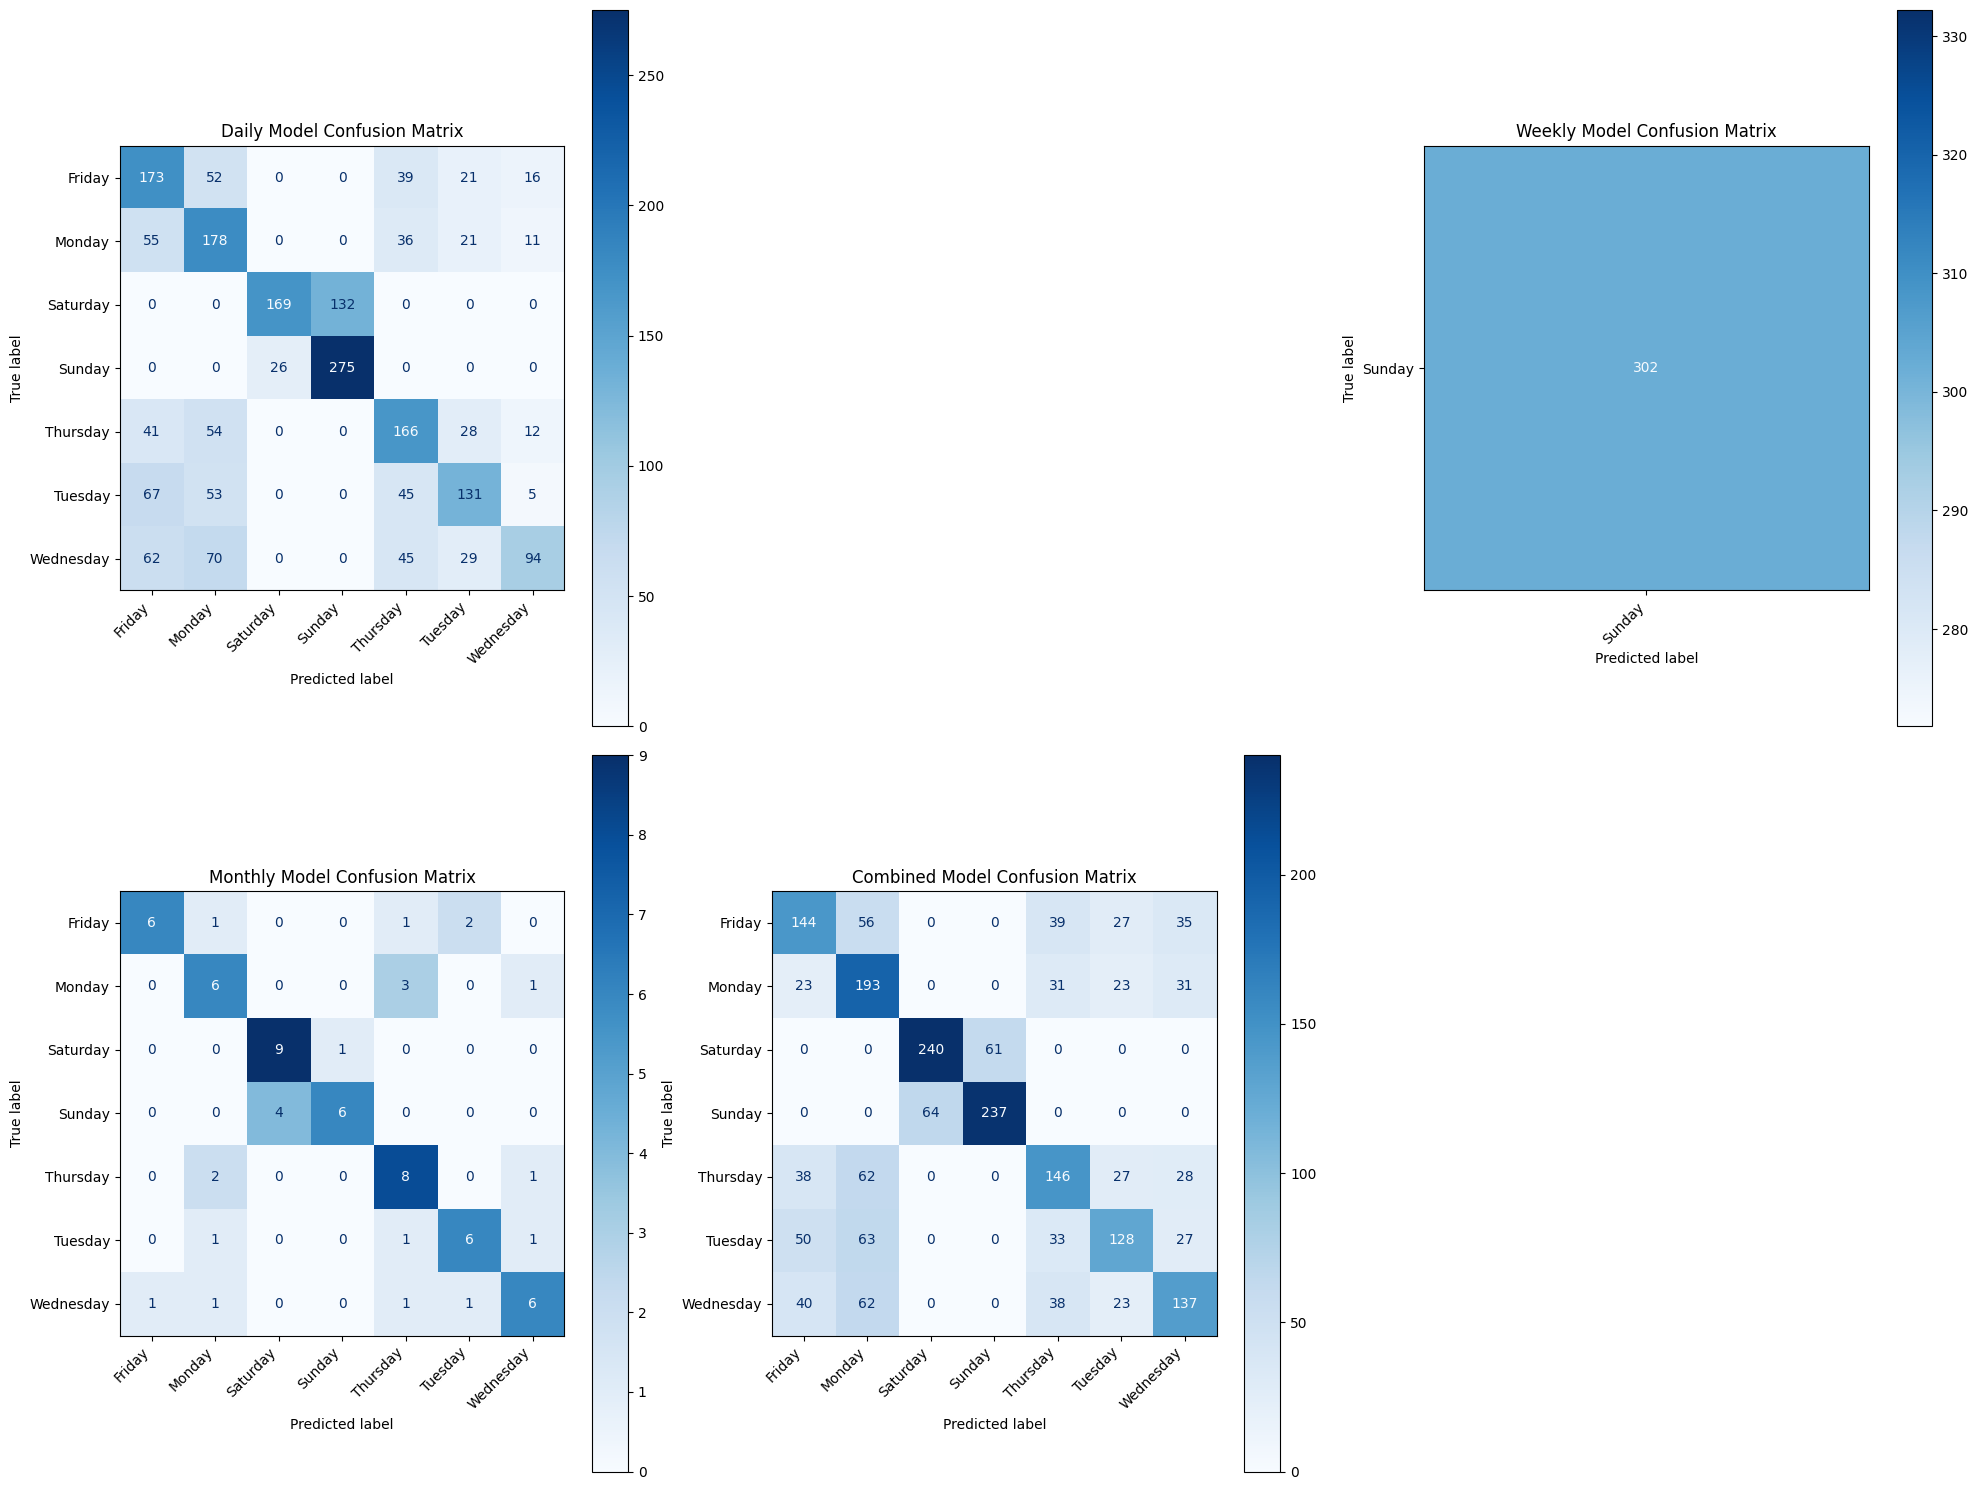

In [17]:
def plot_all_confusion_matrices():
    models = {
        'Daily': (daily_model, X_daily, y_daily),
        'Hourly': (hourly_model, X_hourly, y_hourly),
        'Weekly': (weekly_model, X_weekly, y_weekly),
        'Monthly': (monthly_model, X_monthly, y_monthly),
        'Combined': (combined_model, X_combined, y_combined)
    }
    
    # Set up the subplot grid
    fig = plt.figure(figsize=(20, 15))
    
    for idx, (name, (model, X, y)) in enumerate(models.items(), 1):
        if model is not None and X is not None and y is not None:
            try:
                # Make predictions
                y_pred = model.predict(X)
                
                # Calculate confusion matrix
                cm = confusion_matrix(y, y_pred)
                
                # Create subplot
                plt.subplot(2, 3, idx)
                
                # Plot confusion matrix
                disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                            display_labels=sorted(y.unique()))
                disp.plot(cmap='Blues', ax=plt.gca())
                
                # Customize plot
                plt.title(f'{name} Model Confusion Matrix')
                plt.xticks(rotation=45, ha='right')
                plt.tight_layout()
                
            except Exception as e:
                print(f"Error plotting confusion matrix for {name} model: {e}")
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_all_confusion_matrices()